In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
import scipy.signal as sps

%matplotlib inline

In [2]:
sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

In [34]:
# Connect to DB
zidisha_db = qdb.QueryDatabase('zidisha')

sql_dir = 'SQL_queries'

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

sql_query_short = lambda x: zidisha_db.source_query(sql_dir, x, where_filter_col='country_name', where_filter_list=list_countries)

# Accepted borrower account creation dates
list_df_new_borrowers = sql_query_short('borrowers_w_countries.sql')
for df in list_df_new_borrowers:
    df.insert(0, 'Number of new borrowers', range(len(df)))

# Borrower first loan creation dates
list_df_first_loans = sql_query_short('first_loans_w_countries.sql')
for df in list_df_first_loans:
    df.insert(0, 'Number of first loans', range(len(df)))

# Time to funding
list_df_time_to_fund = sql_query_short('time_to_funding.sql')
    
# Time to disbursement
list_df_time_to_disbursement = sql_query_short('time_to_disbursement.sql')
    
# All loans
list_df_all_loans = sql_query_short('all_loans.sql')

# Fully funded loans
list_df_fully_funded_loans = sql_query_short('fully_funded_loans.sql')

# Load exchange rates
list_df_exchange_start = sql_query_short('exchange_rates_start.sql')

# Invited loans
list_df_invited_loans = sql_query_short('invitee_new_loans.sql')

In [35]:
weeks_per_bin = 1
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, str(weeks_per_bin)+'W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str, col_index=0: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, col_to_bin=col_index, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

df_time_to_fund = bin_short(list_df_time_to_fund, 'median')
df_time_to_disbursement = bin_short(list_df_time_to_disbursement, 'median')

df_usd_requested = bin_short(list_df_all_loans, 'sum', 0)
df_raised_fraction = bin_short(list_df_all_loans, 'median', 1)
df_usd_inflow = bin_short(list_df_all_loans, 'sum', 2)
df_usd_secured = bin_short(list_df_all_loans, 'sum', 3)
df_secured_fraction = df_usd_secured / df_usd_requested

df_usd_requested_new = bin_short(list_df_first_loans, 'sum', 2)
df_raised_fraction_new = bin_short(list_df_first_loans, 'median', 3)
df_usd_inflow_new = bin_short(list_df_first_loans, 'sum', 4)
df_usd_secured_new = bin_short(list_df_first_loans, 'sum', 5)
df_secured_fraction_new = df_usd_secured_new / df_usd_requested_new

df_usd_requested_new_frac = df_usd_requested_new / df_usd_requested
df_usd_secured_new_frac = df_usd_secured_new / df_usd_secured

df_invitee_first_loan_count = bin_short(list_df_invited_loans, 'count')
df_invitee_first_loan_frac = df_invitee_first_loan_count / df_first_loans_count

# Policies
df_loan_loss_fee_kenya = load_Zidisha.loan_loss_reserve_fee_Kenya(time_bins_center)
df_loan_loss_fee_other = load_Zidisha.loan_loss_reserve_fee_Other(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)
df_website_change = load_Zidisha.website_change(time_bins_center)
df_upfront_fee = load_Zidisha.upfront_fee(time_bins_center)


In [6]:
ta = np.array([1,2,3,4])
tb = np.zeros(8)
tb[2:-2] = ta[:]
tb

array([ 0.,  0.,  1.,  2.,  3.,  4.,  0.,  0.])

In [79]:
def rect_window_filter(data: np.array, window_length: int) -> np.array:
    window_length = np.round(window_length)
    if window_length:
        if window_length % 2 == 0:# even
            front_pad = window_length/2
            end_pad = window_length/2
            norm_window = np.repeat(1.0, window_length + 1)
            norm_window[0] = 0.5
            norm_window[-1] = 0.5
            norm_window /= window_length
        else:
            front_pad = (window_length - 1)/2
            end_pad = front_pad
            norm_window = np.repeat(1.0, window_length) / window_length
        data_long = np.pad(data, ((front_pad, end_pad),), mode='edge')
        data_filt = sps.convolve(data_long, norm_window, 'valid')
    else:
        data_filt = data.copy()
    return data_filt

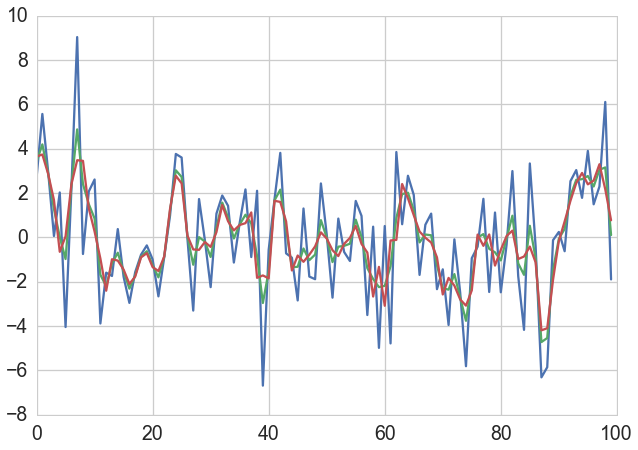

In [81]:
noise = np.random.normal(0,3,100)
lp_noise = rect_window_filter(noise, 2)
lp3_noise = rect_window_filter(noise, 3)
plt.plot(noise)
plt.plot(lp_noise)
plt.plot(lp3_noise)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     109.5
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           4.07e-29
Time:                        23:20:22   Log-Likelihood:                -317.48
No. Observations:                  74   AIC:                             645.0
Df Residuals:                      69   BIC:                             656.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -22.9676     13.743     -1.671      0.0

,0,1,2,3,4
0,1.000000,-0.305447,0.394293,-0.977946,-0.064664
1,-0.305447,1.000000,-0.807754,0.316207,0.147677
2,0.394293,-0.807754,1.000000,-0.477820,-0.331045
3,-0.977946,0.316207,-0.477820,1.000000,0.067882
4,-0.064664,0.147677,-0.331045,0.067882,1.000000


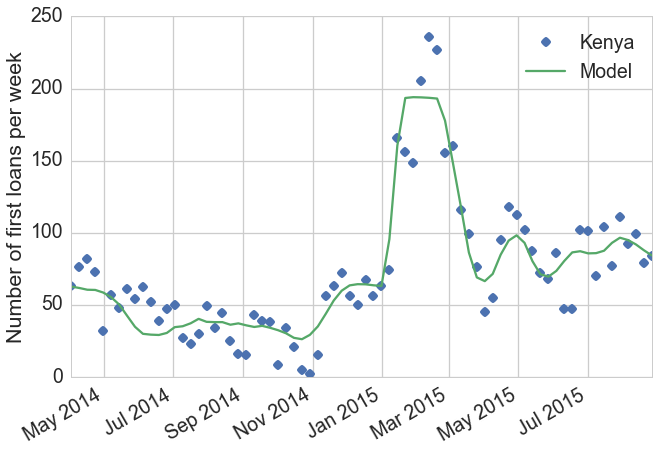

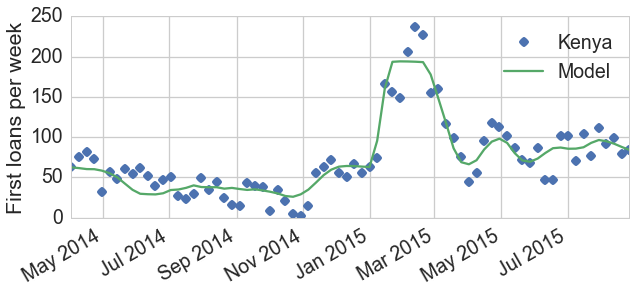

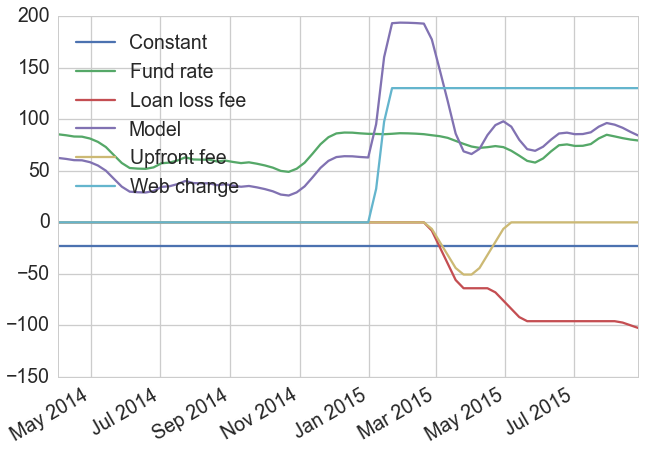

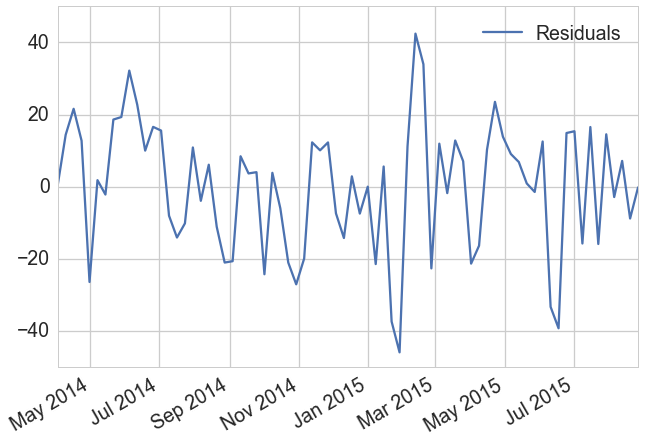

In [94]:
#Fit of Kenya

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = round(4.0 / weeks_per_bin)
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = df_fund_rate.Kenya.values.copy()
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
loan_loss_fee = rect_window_filter(loan_loss_fee, lag_fee*2)
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)
lag_comp3 = round(3.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
web_change = rect_window_filter(web_change, 2)

lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
#upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2)
upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2*lag_upfront)


invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
label_array = df_first_loans_count.Kenya.values[lag:].copy()
time_axis = time_bins_center[lag:].copy()


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change', 'x3: fund rate', 'x4: upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['o', '-'])
plt.ylabel('Number of first loans per week')
#plt.xlabel('Date')


stack_fig_width = 10
stack_fig_height = 1
df_fit2 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, index=time_axis)
df_fit2.plot(figsize=(stack_fig_width, 4*stack_fig_height), style=['o', '-'])
plt.ylabel('First loans per week')


#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

kenya_nlr = label_array.copy()
#kenya_scaled = kenya_nlr.copy() * results.params[0]/results.params[2]
kenya_scaled = kenya_nlr.copy() / results.params[0]
kenya_fit_scaled = results.predict() / results.params[0]

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

kenya_norm_params = results.params / results.params[0]
kenya_norm_bse = results.bse / results.params[0]
print(kenya_norm_params)
print(kenya_norm_bse)

print(kenya_norm_params[2] + 2*np.sqrt(kenya_norm_bse[0]**2 + kenya_norm_bse[2]**2))

m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)

#glm_poisson = sm.GLM(label_array, feature_mat, family=sm.families.Poisson())
#glm_result = glm_poisson.fit()
#print(glm_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     92.09
Date:                Tue, 29 Sep 2015   Prob (F-statistic):           6.45e-27
Time:                        23:27:34   Log-Likelihood:                -294.10
No. Observations:                  74   AIC:                             598.2
Df Residuals:                      69   BIC:                             609.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -31.8299     14.335     -2.220      0.0

,0,1,2,3,4
0,1.000000,-0.310933,0.447488,-0.989287,0.036490
1,-0.310933,1.000000,-0.804580,0.316966,-0.187909
2,0.447488,-0.804580,1.000000,-0.503147,-0.057282
3,-0.989287,0.316966,-0.503147,1.000000,-0.036572
4,0.036490,-0.187909,-0.057282,-0.036572,1.000000


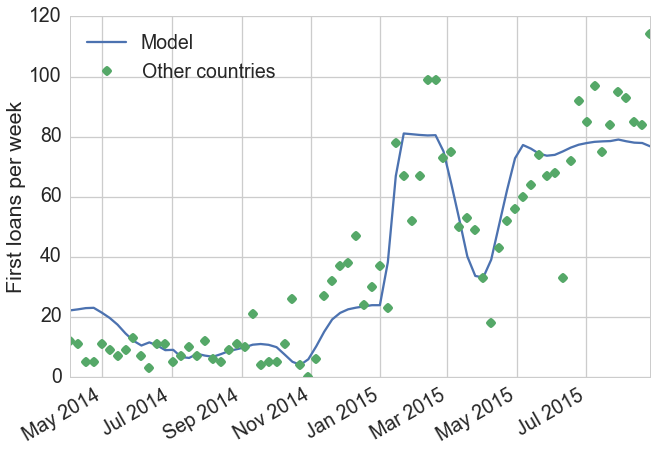

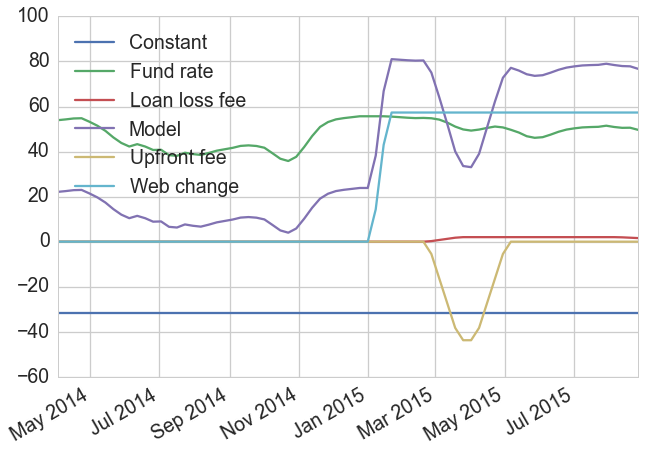

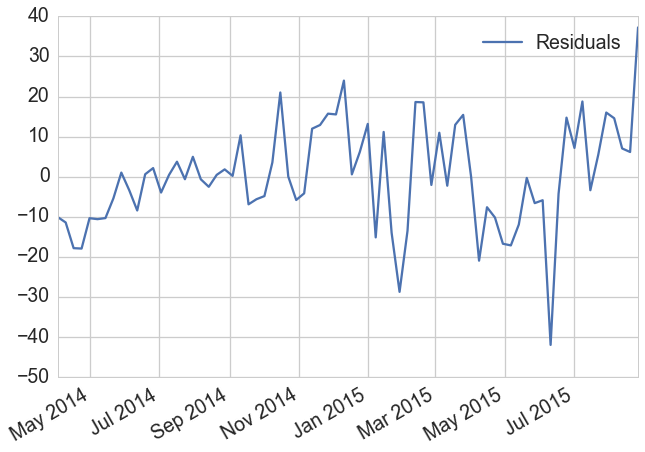

In [95]:
#Fit of other countries

fully_funded_other = df_fully_funded_count.Indonesia.values.copy()
fully_funded_other += df_fully_funded_count.Ghana.values.copy()
fully_funded_other += df_fully_funded_count['Burkina Faso'].values.copy()
all_loans_other = df_all_loans_count.Indonesia.values.copy()
all_loans_other += df_all_loans_count.Ghana.values.copy()
all_loans_other += df_all_loans_count['Burkina Faso'].values.copy()

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

lag = round(4.0 / weeks_per_bin)
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = fully_funded_other / all_loans_other
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
loan_loss_fee = rect_window_filter(loan_loss_fee, lag_fee*2)
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)
lag_comp3 = round(3.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
web_change = rect_window_filter(web_change, 2)

lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
#upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2)
upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2*lag_upfront)



invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_first_loans_count.Indonesia.values[lag:].copy()
label_array += df_first_loans_count.Ghana.values[lag:].copy()
label_array += df_first_loans_count['Burkina Faso'].values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change', 'x3: fund rate', 'x4: upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Other countries': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['-', 'o'])
plt.ylabel('First loans per week')
#plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

other_nlr = label_array.copy()
#other_scaled = other_nlr.copy()# * results.params[0]/results.params[2]
other_scaled = other_nlr.copy() / results.params[0]
other_fit_scaled = results.predict() / results.params[0]

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

other_norm_params = results.params / results.params[0]
other_norm_bse = results.bse / results.params[0]
print(other_norm_params)
print(other_norm_bse)
print(other_norm_params[2] - 2*np.sqrt(other_norm_bse[0]**2 + other_norm_bse[2]**2))


m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)
